## Przygotowanie danych

In [1]:
import glob
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve

from sklearn import metrics
from sklearn.inspection import permutation_importance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.metrics import classification_report

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

/home/anna_s/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/anna_s/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/anna_s/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/anna_s/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index 

In [2]:
# funkcja do sortowania danych
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Klasyfikacja

In [3]:
def data_to_model(fold):
    # ścieżka do folderów w którym są pliki .tar
    path_to_name='02_DANE/process/DANE_DLA_ANI/processed_bands_pow_ph/_coh/fold={}'.format(fold)

    # tworzenie listy nazw z plików .tar
    name_fold=[x.split('/')[-1].split('.')[0] for x in sorted(glob.glob('{}/*.tar'.format(path_to_name)),key=numericalSort)]
    
    # wczytujemy zbiór danych
    results=pd.read_csv('02_DANE/process/up_processed_bands_pow_ph/up_fold={}/fold_{}.csv'.format(fold,fold))
    
    # tworzymy zbiór danych tylko dla pacjentów zdrowych gdzie klasa =0
    results1=results[results['class']==0]
    
    # tworzenie listy z nazwami wszytskich plików .npy z wszytskich folderów
    # tworznie kluczy do słownika
    npy_files=[]
    for n_fold in name_fold:
        npy = [x for x in sorted(glob.glob('02_DANE/process/up_processed_bands_pow_ph/up_fold={}/{}/*.npy'.format(fold,n_fold)),key=numericalSort)]
        npy_files.extend(npy)
    
    # tworznie wartości do słownika
    npy_v=['{}.data.npy'.format(x) for x in results['num'] ]
    
    # tworzenie słownika
    dict_npy = dict(zip(npy_files,npy_v))
    # tworzenie listy .npy gdzie klasa =0
    npy_1=['{}.data.npy'.format(x) for x in results1['num'] ]
    
    # tworzenie listy ścieżek do plików .npy gdzie klasa =0 w celu pobrania odpowiednich plików .npy z folderów
    list_name=[]
    for key, value in dict_npy.items():
        if value in npy_1:
            list_name.append(key)
    
    # przygotowanie macierzy cech
    X_train=[]
    for x in list_name:
        X_train.append(np.load('{}'.format(x)))
    X=np.array(X_train)
    
    # przygotowanie targetu
    y=results1['age_int']
    
    return X,y

In [4]:
# ładowanie danych dla wszytskich 'fold'ów' uwzględniając tylko pacjentów zdrowych
X_fold1,y_fold1=data_to_model(1)
X_fold2,y_fold2=data_to_model(2)
X_fold3,y_fold3=data_to_model(3)
X_fold4,y_fold4=data_to_model(4)
X_fold5,y_fold5=data_to_model(5)
X_fold6,y_fold6=data_to_model(6)

In [5]:
X_all=np.concatenate((X_fold1, X_fold2, X_fold3, X_fold4, X_fold5, X_fold6))

In [6]:
y_all=pd.concat((y_fold1, y_fold2, y_fold3, y_fold4, y_fold5, y_fold6))

In [7]:
X_all.shape, y_all.shape

((21561, 1653), (21561,))

### Wizualizacja danych 'age'

In [8]:
# funkcja do tworzenia histogramów
def check_data(y):
    unique, counts_train = np.unique(y, return_counts=True)
    
    plt.figure(figsize=(8, 5))
    plt.bar(y_all.unique(), counts_train)
    plt.ylabel('value_counts')
    plt.title('age_int')
    plt.xticks(rotation='vertical')
    plt.show()

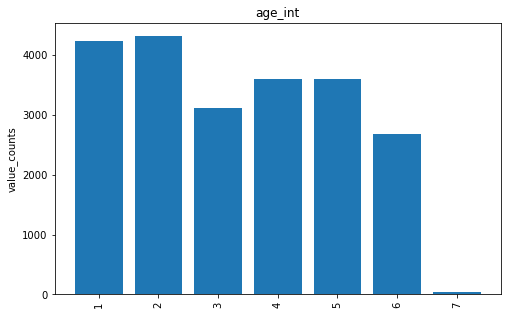

In [16]:
check_data(y_all)

## model Random Forest Classifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2022)

In [10]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (15092, 1653) (15092,)
Test: (6469, 1653) (6469,)


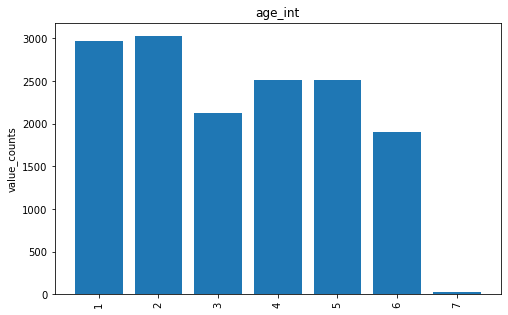

In [11]:
check_data(y_train)

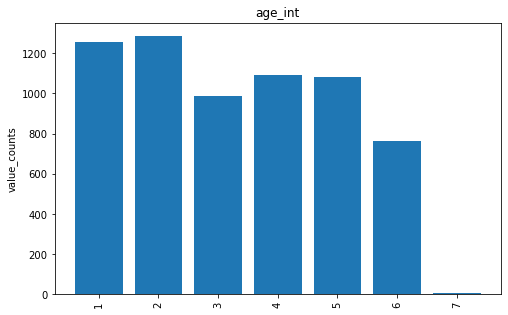

In [12]:
check_data(y_test)

In [40]:
# trenowanie modelu - pacjenci zdrowi
model = RandomForestClassifier(random_state=2022, max_depth=20, n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
print(metrics.accuracy_score(y_test, y_pred))

0.41304683876951614


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.55      0.57       985
           2       0.40      0.55      0.46      1287
           3       0.35      0.36      0.35      1254
           4       0.35      0.24      0.28      1082
           5       0.39      0.46      0.43      1092
           6       0.46      0.28      0.35       761
           7       0.00      0.00      0.00         8

    accuracy                           0.41      6469
   macro avg       0.36      0.35      0.35      6469
weighted avg       0.42      0.41      0.41      6469



/home/anna_s/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


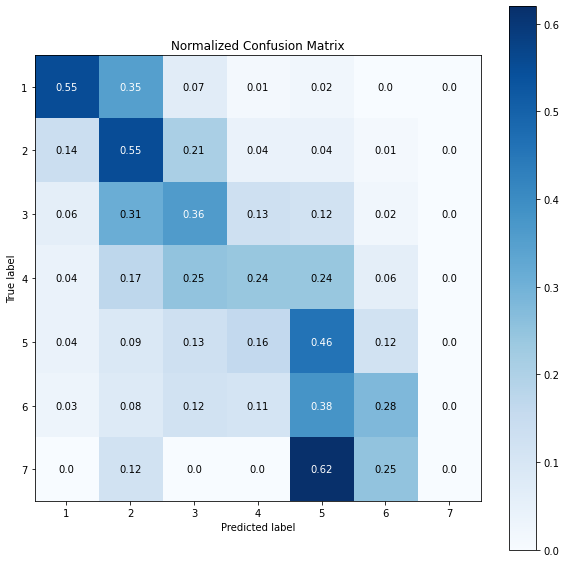

In [48]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10 ,10));

In [42]:
print( pd.Series(y_pred).value_counts() )

2    1785
5    1289
3    1285
1     911
4     745
6     454
dtype: int64


/home/anna_s/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


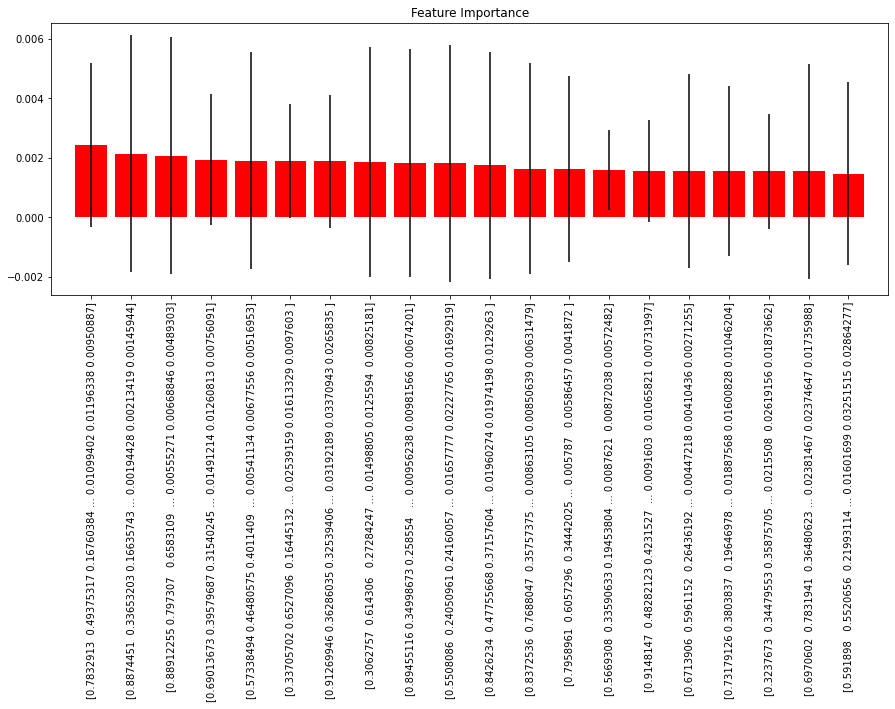

In [50]:
skplt.estimators.plot_feature_importances(model, feature_names=X_train, x_tick_rotation=90, figsize=(15, 5));

In [52]:
#skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='accuracy');

## model XGBClassifier

In [60]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[21:31:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
print(metrics.accuracy_score(y_test, y_pred))

0.4125830885762869


In [13]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=60)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/home/anna_s/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:05:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
print(metrics.accuracy_score(y_test, y_pred))

0.420312258463441


In [15]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=90)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[08:27:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
print(metrics.accuracy_score(y_test, y_pred))

0.42618642757767816


In [17]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[09:47:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
print(metrics.accuracy_score(y_test, y_pred))

0.43468851445354767


### Baysian optimalization

In [68]:
# https://github.com/MamczurMiroslaw/gradient_boosting_example/blob/master/Hyperparameters_optimalization_example.ipynb

In [28]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred, average='macro',multi_class='ovo')
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d

def calculating_metrics(X_train, X_val, X_oot, y_train, y_val, y_oot):
    test = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    val = create_measures(y_val,model.predict_proba(X_val)[:, 1])
    oot = create_measures(y_oot,model.predict_proba(X_oot)[:, 1]) 

    measures =  pd.concat([test,val,oot]).set_index([pd.Index(['TRAIN', 'VAL', 'OOT'])]) 
    
    return measures

In [ ]:
#model = xgb.XGBClassifier(tree_method='gpu_hist')
#model.fit(X_train, y_train)  

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2022)

In [ ]:
# https://stackoverflow.com/questions/63303682/sklearn-multiclass-roc-auc-score
#measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
#measures

# Regresja

In [3]:
def data_to_model(fold):
    # ścieżka do folderów w którym są pliki .tar
    path_to_name='02_DANE/process/DANE_DLA_ANI/processed_bands_pow_ph/_coh/fold={}'.format(fold)

    # tworzenie listy nazw z plików .tar
    name_fold=[x.split('/')[-1].split('.')[0] for x in sorted(glob.glob('{}/*.tar'.format(path_to_name)),key=numericalSort)]
    
    # wczytujemy zbiór danych
    results=pd.read_csv('02_DANE/process/up_processed_bands_pow_ph/up_fold={}/fold_{}.csv'.format(fold,fold))
    
    # tworzymy zbiór danych tylko dla pacjentów zdrowych gdzie klasa =0
    results1=results[results['class']==0]
    
    # tworzenie listy z nazwami wszytskich plików .npy z wszytskich folderów
    # tworznie kluczy do słownika
    npy_files=[]
    for n_fold in name_fold:
        npy = [x for x in sorted(glob.glob('02_DANE/process/up_processed_bands_pow_ph/up_fold={}/{}/*.npy'.format(fold,n_fold)),key=numericalSort)]
        npy_files.extend(npy)
    
    # tworznie wartości do słownika
    npy_v=['{}.data.npy'.format(x) for x in results['num'] ]
    
    # tworzenie słownika
    dict_npy = dict(zip(npy_files,npy_v))
    # tworzenie listy .npy gdzie klasa =0
    npy_1=['{}.data.npy'.format(x) for x in results1['num'] ]
    
    # tworzenie listy ścieżek do plików .npy gdzie klasa =0 w celu pobrania odpowiednich plików .npy z folderów
    list_name=[]
    for key, value in dict_npy.items():
        if value in npy_1:
            list_name.append(key)
    
    # przygotowanie macierzy cech
    X_train=[]
    for x in list_name:
        X_train.append(np.load('{}'.format(x)))
    X=np.array(X_train)
    
    # przygotowanie targetu
    y=results1['age']
    
    return X,y,results1

In [4]:
# ładowanie danych dla wszytskich 'fold'ów' uwzględniając tylko pacjentów zdrowych
X_fold1,y_fold1, df_fold1=data_to_model(1)
X_fold2,y_fold2, df_fold2=data_to_model(2)
X_fold3,y_fold3, df_fold3=data_to_model(3)
X_fold4,y_fold4, df_fold4=data_to_model(4)
X_fold5,y_fold5, df_fold5=data_to_model(5)
X_fold6,y_fold6, df_fold6=data_to_model(6)

In [5]:
X_all=np.concatenate((X_fold1, X_fold2, X_fold3, X_fold4, X_fold5, X_fold6))

In [6]:
y_all=pd.concat((y_fold1, y_fold2, y_fold3, y_fold4, y_fold5, y_fold6))

In [7]:
df_all=pd.concat((df_fold1, df_fold2, df_fold3, df_fold4, df_fold5, df_fold6))

In [8]:
#df_all.head(5)

In [9]:
X_all.shape, y_all.shape

((21561, 1653), (21561,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2022)

In [11]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (15092, 1653) (15092,)
Test: (6469, 1653) (6469,)


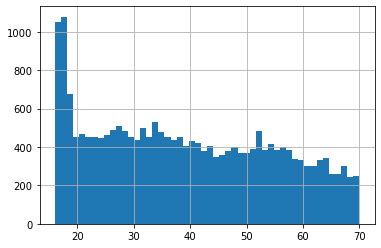

In [12]:
y_all.hist(bins=50);

In [15]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve


import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
    
import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
Wall time: 12.8 s
CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 12.7 ms


0.2868627800425567

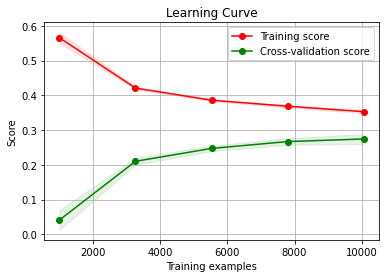

In [57]:
model = DecisionTreeRegressor(random_state=2022, max_depth=5)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

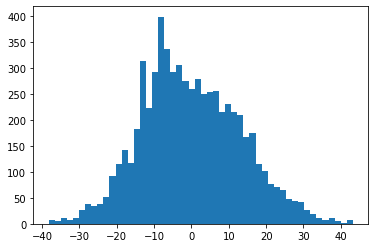

In [58]:
plt.hist(y_test - y_pred, bins=50);

CPU times: user 1min 16s, sys: 3.9 ms, total: 1min 16s
Wall time: 1min 16s
CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 14 ms


0.35567632118411385

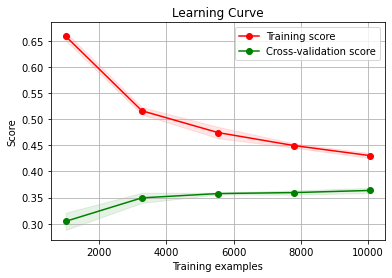

In [59]:
model = RandomForestRegressor(random_state=2022, n_estimators=10, max_depth=5)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

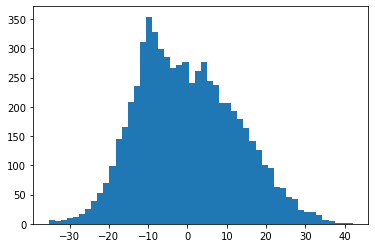

In [60]:
plt.hist(y_test - y_pred, bins=50);

In [61]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=2022)
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

CPU times: user 18min 35s, sys: 767 ms, total: 18min 36s
Wall time: 2min 20s
CPU times: user 388 ms, sys: 32 ms, total: 420 ms
Wall time: 86.3 ms


0.5412161105251329

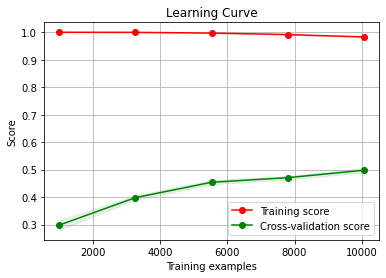

In [62]:
%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)plt.hist(y_test - y_pred, bins=50);

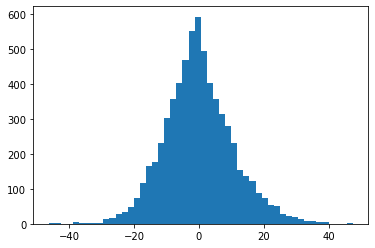

In [63]:
plt.hist(y_test - y_pred, bins=50);

CPU times: user 1min 7s, sys: 1.2 s, total: 1min 8s
Wall time: 11.9 s
CPU times: user 413 ms, sys: 1e+03 ns, total: 413 ms
Wall time: 382 ms


0.5420487025504264

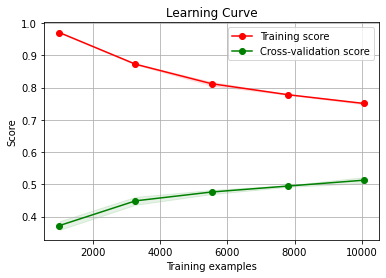

In [64]:
model = ctb.CatBoostRegressor(n_estimators=100, depth=5, random_state=2022, verbose=False)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

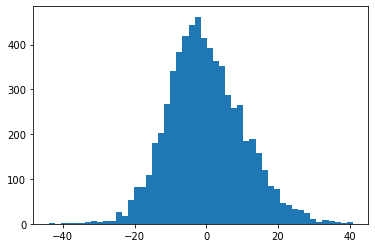

In [65]:
plt.hist(y_test - y_pred, bins=50);

In [12]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_squared_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
 

In [13]:
   
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}

In [16]:
trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [1:42:49<00:00, 205.64s/trial, best loss: 105.12267626997502]
The best params:  {'x_colsample_bytree': 0.9107969979259879, 'x_learning_rate': 0.11245862126665093, 'x_max_depth': 7.0, 'x_min_child_weight': 5.0, 'x_random_state': 5900.0, 'x_reg_alpha': 2.7121363084818517, 'x_reg_lambda': 0.7810419097968127, 'x_subsample': 0.9582115518072755}


In [17]:
trials.best_trial

{'state': 2,
 'tid': 11,
 'spec': None,
 'result': {'loss': 105.12267626997502, 'status': 'ok'},
 'misc': {'tid': 11,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [11],
   'x_learning_rate': [11],
   'x_max_depth': [11],
   'x_min_child_weight': [11],
   'x_random_state': [11],
   'x_reg_alpha': [11],
   'x_reg_lambda': [11],
   'x_subsample': [11]},
  'vals': {'x_colsample_bytree': [0.9107969979259879],
   'x_learning_rate': [0.11245862126665093],
   'x_max_depth': [7.0],
   'x_min_child_weight': [5.0],
   'x_random_state': [5900.0],
   'x_reg_alpha': [2.7121363084818517],
   'x_reg_lambda': [0.7810419097968127],
   'x_subsample': [0.9582115518072755]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 12, 8, 11, 28, 19, 190000),
 'refresh_time': datetime.datetime(2022, 12, 8, 11, 30, 58, 231000)}

In [18]:
type(X_test)

numpy.ndarray

In [40]:
dataframe_train = pd.DataFrame.from_records(X_train)

In [20]:
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Columns: 1653 entries, 0 to 1652
dtypes: float32(1653)
memory usage: 95.2 MB


In [21]:
dataframe_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652
0,0.948392,0.807233,0.634927,0.795152,0.689951,0.808429,0.360581,0.324411,0.274222,0.485078,...,0.036672,0.041285,0.045557,0.045326,0.062304,0.065491,0.038242,0.014110,0.018287,0.013729
1,0.746620,0.575926,0.214289,0.517099,0.307934,0.401059,0.521206,0.516610,0.191877,0.430831,...,0.036164,0.023736,0.016015,0.011243,0.011759,0.008217,0.004201,0.002672,0.003413,0.002757


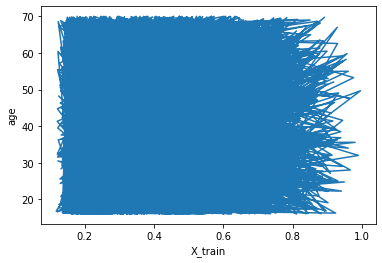

In [48]:
plt.plot(dataframe_train[6],y_train)
plt.xlabel('X_train')
plt.ylabel('age')
plt.show()

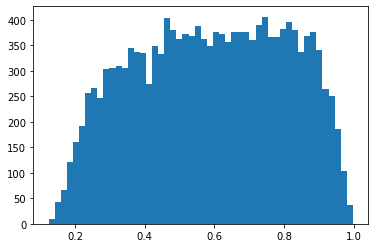

In [24]:
plt.hist(dataframe_train[0], bins=50);

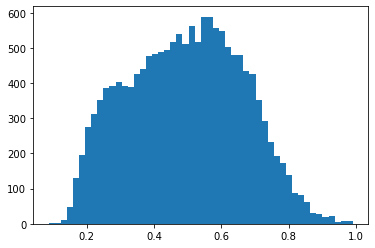

In [27]:
plt.hist(dataframe_train[1], bins=50);

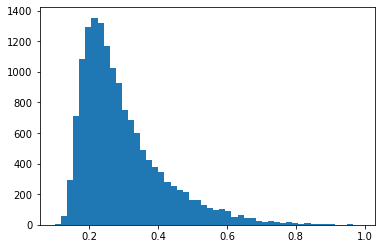

In [28]:
plt.hist(dataframe_train[2], bins=50);

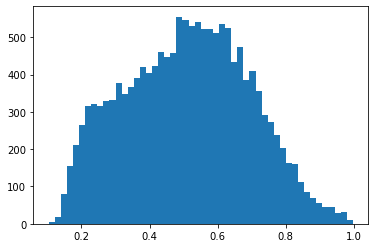

In [29]:
plt.hist(dataframe_train[3], bins=50);

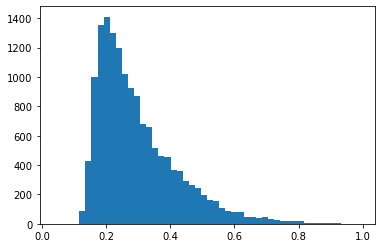

In [30]:
plt.hist(dataframe_train[4], bins=50);

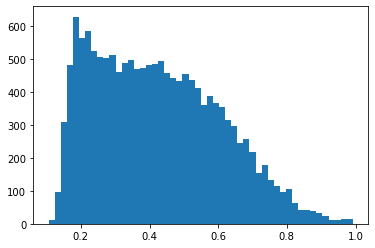

In [31]:
plt.hist(dataframe_train[5], bins=50);

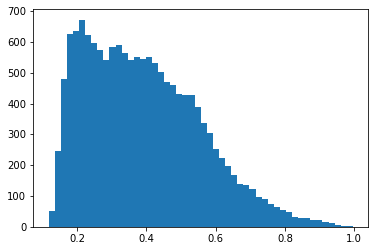

In [32]:
plt.hist(dataframe_train[6], bins=50);

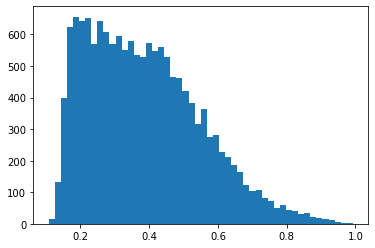

In [36]:
plt.hist(dataframe_train[7], bins=50);

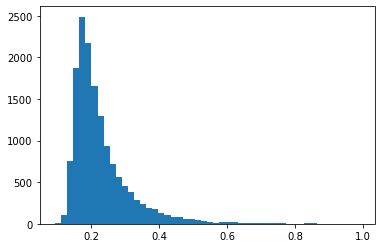

In [44]:
plt.hist(dataframe_train[8], bins=50);

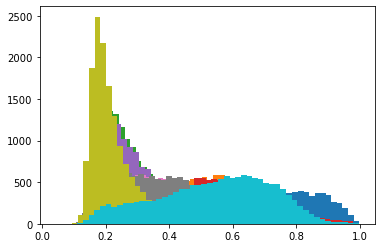

In [25]:
for x in range(10):
    plt.hist(dataframe_train[x], bins=50);

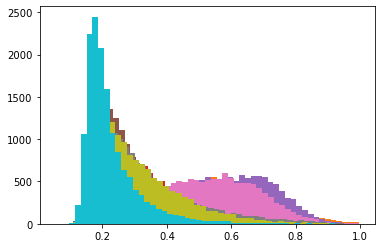

In [26]:
for x in range(10,20):
    plt.hist(dataframe_train[x], bins=50);

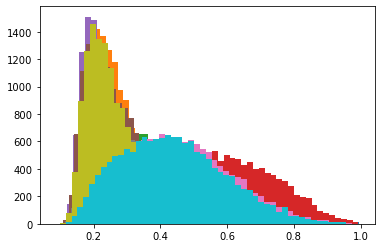

In [45]:
for x in range(20,30):
    plt.hist(dataframe_train[x], bins=50);

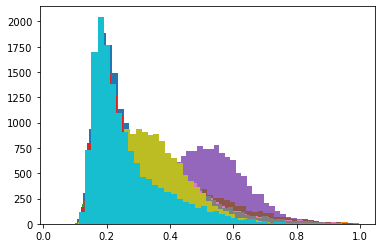

In [46]:
for x in range(30,40):
    plt.hist(dataframe_train[x], bins=50);

In [34]:
# https://www.kaggle.com/code/sumitdewang/sumit-dewang-bike-sharing-rental-demand

In [14]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge

# For Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import BernoulliNB, GaussianNB,MultinomialNB
from xgboost import XGBRegressor,XGBRFRegressor

#Evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


### Linear Regression

In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [18]:
y_pred = lr_model.predict(X_test)
y_pred[5:10]

array([21.049004, 34.381737, 53.40468 , 28.975792, 30.961067],
      dtype=float32)

In [19]:
y_test[5:10]

7241    22.073922
4188    33.416667
1192    50.500000
3861    19.083333
2817    17.666667
Name: age, dtype: float64

In [21]:
# Training Data Evaluation

y_pred_train = lr_model.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2 = r2_score(y_train, y_pred_train)
print('R-Squared :',r2)

MSE : 88.02432830411692
RMSE : 9.38212813300463
MAE : 7.306077597670537
R-Squared : 0.6415078095256008


In [22]:
# Testing Data Evaluation
y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 115.03930434263046
RMSE : 10.725637712631844
MAE : 8.367077904492469
R-Squared : 0.5326982081908171


Regularization

In [23]:
ridge_model = Ridge(alpha=0.08) #Alpha = Lambda >> Hyperparameter 
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.08)

In [24]:
# Training Data Accuracy
y_pred_train = ridge_model.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Testing MSE is:",mse)
r2 = r2_score(y_train,y_pred_train)
print("Testing R2 score is:",r2)

Testing MSE is: 88.48611936731089
Testing R2 score is: 0.6396270966252542


In [25]:
# Testing data

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("Testing MSE is:",mse)
r2 = r2_score(y_test,y_pred)
print("Testing R2 score is:",r2)

Testing MSE is: 112.7848188855989
Testing R2 score is: 0.5418561659835799


### Decision Tree

In [26]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)

DecisionTreeRegressor()

In [27]:
# Training Data Evaluation

y_pred_train = dt_reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2 = r2_score(y_train, y_pred_train)
print('R-Squared :',r2)

MSE : 0.26759213758071243
RMSE : 0.5172930867319923
MAE : 0.019932961628787806
R-Squared : 0.9989101911550679


In [28]:
# Testing Data Evaluation
y_pred = dt_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 263.33867638744067
RMSE : 16.227713221136263
MAE : 12.052618202073406
R-Squared : -0.06970948782856423


Hyperparameter Tunning for Decision Tree

In [39]:
dt_reg = DecisionTreeRegressor()

hyperparameters ={ "criterion" :['mse','mae'],
     'max_depth': np.arange(3,14),
     'min_samples_split' : np.arange(2,20),
     'min_samples_leaf':np.arange(2,15)}

#gscv_dt_reg = RandomizedSearchCV(dt_reg,hyperparameters, cv = 5,n_jobs=-1)
#gscv_dt_reg.fit(X_train, y_train)
#gscv_dt_reg.best_estimator_

In [ ]:
dt_reg = gscv_dt_reg.best_estimator_
dt_reg.fit(X_train, y_train)

### XGBoost

In [30]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
# Training Data Evaluation
y_pred_train = xgb_reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2_value = r2_score(y_train, y_pred_train)
print("R-Squared Value is :",r2_value)

MSE : 9.248963513869722
RMSE : 3.0412108631053063
MAE : 2.2557994143602156
R-Squared Value is : 0.9623322182221086


In [32]:
# Testing Data Evaluation
y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 112.94238629914418
RMSE : 10.627435546694421
MAE : 8.143869198879969
R-Squared : 0.5412161105251329


In [55]:
y_pred[950:955]

array([41.197613, 34.226883, 60.85134 , 41.656998, 35.986813],
      dtype=float32)

In [56]:
y_test[950:955]

2793    40.583333
1185    47.000000
5882    53.500000
1343    29.666667
1385    21.750000
Name: age, dtype: float64

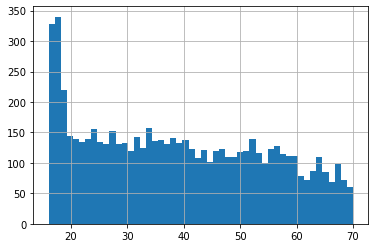

In [57]:
y_test.hist(bins=50);

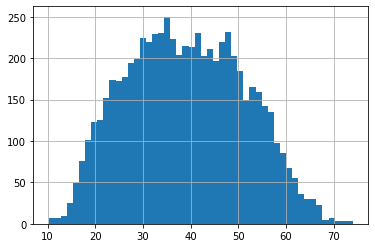

In [59]:
pd.Series(y_pred).hist(bins=50);

Hyper parameter tuning XGBoost

In [36]:
space ={
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('x_max_depth', 1, 9, 1),
    'n_estimators': hp.quniform ('x_n_estimators', 100, 1000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 0, 100, 1),
    'gamma': hp.loguniform ('x_gamma', 0.0, 2.0),
    'subsample': hp.uniform ('x_subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('x_colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.loguniform ('x_reg_lambda', 0.0, 2.0),
}

In [37]:
def objective(space):
    xgb_params = {
        # ogólne
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'gamma': space['gamma'],
        'seed': 2022,
        # do walki z overfiting
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'colsample_bylevel': space['colsample_bylevel'],
        # regularyzacja
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        # pozostałe
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    score = r2_score(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

In [38]:
trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

[11:27:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/30 [3:22:49<?, ?trial/s, best loss=?]


KeyboardInterrupt: 